<a href="https://colab.research.google.com/github/mohsenmolaei/seriesnet_based/blob/main/TSAseriesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pdb
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
!pip install yfinance
import yfinance as yf

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/tripple stage seriesnet"
import TSASeriesNet

if torch.cuda.is_available():
    # dev = "TPU:0"
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print(device)

In [ ]:
data= pd.read_csv('data.csv')
data.set_index("time_stamp",inplace=True,drop=True)
data
label_encoder = LabelEncoder()
n_bins = 50
data['difficulty_latest'] = data['difficulty_latest'].astype(float)
data['hash_rate_mean'] = data['hash_rate_mean'].astype(float)

data['difficulty_latest'] = label_encoder.fit_transform(pd.cut(data['difficulty_latest'] , n_bins, retbins=True)[0])
data['hash_rate_mean'] = label_encoder.fit_transform(pd.cut(data['hash_rate_mean'], n_bins, retbins=True)[0])

whatcol=[ 'price_drawdown_relative','difficulty_latest',
           'hash_rate_mean', 'active_more_1y_percent', 'utxo_created_value_median', 
           'transfers_volume_median', 'utxo_spent_value_median']

X, Y = data[whatcol], np.array(data.price_usd_close)
print(X.shape)
print(Y.shape)
X

(2643, 7)
(2643,)


,price_drawdown_relative,difficulty_latest,hash_rate_mean,active_more_1y_percent,utxo_created_value_median,transfers_volume_median,utxo_spent_value_median
time_stamp,,,,,,,
2016-01-01,-0.625952,0,0,0.604683,0.016258,0.229779,0.023695
2016-01-02,-0.625919,0,0,0.604778,0.010013,0.171285,0.010108
2016-01-03,-0.629293,0,0,0.604672,0.009600,0.213202,0.019593
2016-01-04,-0.626796,0,0,0.604670,0.023020,0.215714,0.019541
2016-01-05,-0.627429,0,0,0.604726,0.023085,0.255841,0.025148
...,...,...,...,...,...,...,...
2023-03-23,-0.587806,41,47,0.679460,0.003454,0.015321,0.004405
2023-03-24,-0.600727,41,46,0.679404,0.003405,0.014836,0.004000
2023-03-25,-0.600118,41,42,0.680026,0.002571,0.010276,0.003489


In [ ]:
""" Condition_train """
feature = ["CPI", "DXYN", "GBPUSD=X", "^TNX", "^DJI", "EURUSD=X", "SI=F", "^RUT", "CL=F", "^IXIC", "GC=F", "N225", "^FTSE"]
start = "2016-1-1"
end="2023-3-28"
try : 
    data_CPI = yf.download("CL=F CPI DXYN GC=F  SI=F ^DJI ^IXIC ^RUT ^TNX" ,start=start, end=end , interval ="1d") #1137
except Exception as e: 
    print("error")
data_CPI.set_index(pd.to_datetime(data_CPI.index).date,inplace=True) 
try : 
    EURUSD = yf.download("EURUSD=X GBPUSD=X ^FTSE" ,start=start, end=end , interval ="1d") #1176 
except Exception as e: 
    print("error")
EURUSD.set_index(pd.to_datetime(EURUSD.index).date,inplace=True) 
try : 
    N225 = yf.download("^N225" ,start=start, end=end , interval ="1d") #1095 
    N225.rename(columns={'Close': 'N225'}, inplace=True)
except Exception as e: 
    print("error")
N225.set_index(pd.to_datetime(N225.index).date,inplace=True) 

merged_df = pd.merge(data_CPI.Close, EURUSD.Close , left_index=True, right_index=True, how='outer')
merged_df.fillna(method='ffill', inplace=True) 
Condition = pd.merge(merged_df, N225.N225 , left_index=True, right_index =True, how='outer')
Condition.fillna(method='ffill', inplace=True) 

try:
    data_crypto = yf.download("BTC-USD" ,start=start, end=end , interval ="1d")
except Exception as e: 
    print("error")
data_crypto.set_index(pd.to_datetime(data_crypto.index).date,inplace=True) 
merged_df = pd.merge(data_crypto.Close, Condition , left_index=True, right_index=True, how='outer')
merged_df.fillna(method='bfill', inplace=True)  
# merged_df.fillna(method='', inplace=True)  

ccol = ['CL=F', 'CPI', 'DXYN', 'GC=F', 'SI=F', '^DJI', '^IXIC', '^RUT', '^TNX','EURUSD=X', 'GBPUSD=X', '^FTSE', 'N225']
Condition = merged_df[ccol]
Condition

,CL=F,CPI,DXYN,GC=F,SI=F,^DJI,^IXIC,^RUT,^TNX,EURUSD=X,GBPUSD=X,^FTSE,N225
2016-01-01,36.759998,26.530001,5.03,1075.099976,13.817000,17148.939453,4903.089844,1108.619995,2.245,1.085906,1.473839,6093.399902,18450.980469
2016-01-02,36.759998,26.530001,5.03,1075.099976,13.817000,17148.939453,4903.089844,1108.619995,2.245,1.085906,1.473839,6093.399902,18450.980469
2016-01-03,36.759998,26.530001,5.03,1075.099976,13.817000,17148.939453,4903.089844,1108.619995,2.245,1.085906,1.473839,6093.399902,18450.980469
2016-01-04,36.759998,26.530001,5.03,1075.099976,13.817000,17148.939453,4903.089844,1108.619995,2.245,1.085399,1.473709,6093.399902,18450.980469
2016-01-05,35.970001,26.420000,4.90,1078.400024,13.949000,17158.660156,4891.430176,1110.439941,2.248,1.082755,1.471410,6137.200195,18374.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-23,69.959999,24.860001,0.72,1993.800049,23.143999,32105.250000,11787.400391,1720.290039,3.406,1.087039,1.227973,7499.600098,27419.609375
2023-03-24,69.260002,24.900000,0.77,1982.099976,23.247000,32237.529297,11823.959961,1734.920044,3.380,1.083506,1.228154,7405.500000,27385.250000
2023-03-25,69.260002,24.900000,0.77,1982.099976,23.247000,32237.529297,11823.959961,1734.920044,3.380,1.083506,1.228154,7405.500000,27385.250000
2023-03-26,69.260002,24.900000,0.77,1982.099976,23.247000,32237.529297,11823.959961,1734.920044,3.380,1.083506,1.228154,7405.500000,27385.250000


In [ ]:
"""# scale features""" 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
MMScaler = MinMaxScaler()
SScaler = StandardScaler()
condscaler = StandardScaler()

X_trans = SScaler.fit_transform(X)
c_trans = condscaler.fit_transform(Condition)
y_trans = MMScaler.fit_transform(Y.reshape(-1, 1))
print(X_trans.shape)
print(c_trans.shape)
print(y_trans.shape)


"""# split a multivariate sequence past, future samples (X and y)"""
def split_sequences(input_sequences, condition_seq, output_sequence, n_steps_in, n_steps_out):
    X, C, y = list(),list(), list() 
    for i in range(len(input_sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out 
        if out_end_ix >= len(input_sequences): break
        seq_x, seq_c, seq_y = input_sequences[i:end_ix], condition_seq[i:end_ix], output_sequence[end_ix:out_end_ix]
        X.append(seq_x), C.append(seq_c) ,y.append(seq_y)
    return np.array(X), np.array(C), np.array(y)

x_shape = 30
y_shape = 3
X_ss, C_ss, y_mm = split_sequences(X_trans, c_trans, y_trans, x_shape, y_shape)
print(X_ss.shape, C_ss.shape, y_mm.shape)

total_samples = len(X)
train_test_cutoff = round(0.85 * total_samples)

X_train = X_ss[:-(total_samples-train_test_cutoff)]
C_train = C_ss[:-(total_samples-train_test_cutoff)]
X_test = X_ss[-(total_samples-train_test_cutoff):]
C_test = C_ss[-(total_samples-train_test_cutoff):]

y_train = y_mm[:-(total_samples-train_test_cutoff)]
y_test = y_mm[-(total_samples-train_test_cutoff):] 

print(total_samples - train_test_cutoff)
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

"""# convert to pytorch tensors"""
X_train_tensors = Variable(torch.Tensor(X_train).to(device))
X_test_tensors = Variable(torch.Tensor(X_test).to(device))

C_train_tensors = Variable(torch.Tensor(C_train).to(device))
C_test_tensors = Variable(torch.Tensor(C_test).to(device))

y_train_tensors = Variable(torch.Tensor(y_train).to(device))
y_test_tensors = Variable(torch.Tensor(y_test).to(device))

print(X_train_tensors.shape)
print(C_train_tensors.shape)

"""# reshaping to rows, timestamps, features"""

X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], x_shape, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], x_shape, 
                                      X_test_tensors.shape[2])) 

C_train_tensors_final = torch.reshape(C_train_tensors,   
                                      (C_train_tensors.shape[0], x_shape, 
                                       C_train_tensors.shape[2]))
C_test_tensors_final = torch.reshape(C_test_tensors,  
                                     (C_test_tensors.shape[0], x_shape, 
                                      C_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, C_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, C_test_tensors_final.shape, y_test_tensors.shape)



(2643, 7)
(2643, 13)
(2643, 1)
(2610, 30, 7) (2610, 30, 13) (2610, 3, 1)
396
Training Shape: (2214, 30, 7) (2214, 3, 1)
Testing Shape: (396, 30, 7) (396, 3, 1)
torch.Size([2214, 30, 7])
torch.Size([2214, 30, 13])
Training Shape: torch.Size([2214, 30, 7]) torch.Size([2214, 30, 13]) torch.Size([2214, 3, 1])
Testing Shape: torch.Size([396, 30, 7]) torch.Size([396, 30, 13]) torch.Size([396, 3, 1])


In [ ]:
# %%
def RMSELoss(yhat,y): #NRMSE
    # pdb.set_trace()
    y = y.reshape(y.shape[0], y.shape[1])
    return (torch.sqrt(torch.mean((yhat-y)**2)))/ (torch.max(y) - torch.min(y))

def MAPELoss(yhat,y):
    return torch.mean(abs(yhat-y)/abs(y))

In [ ]:
def training_loop(n_epochs,learning_rate, lr_decay_epoch, network, optimiser, loss_fn, X_train, Condition_train, y_train,
                  X_test, Condition_test, y_test):
    loss_valid_show,loss_train_show = [],[]
    
    def exp_lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=200):
        lr = init_lr * (0.9**(epoch // lr_decay_epoch))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return optimizer

    if torch.cuda.is_available():
        network.cuda()
        
    for epoch in range(n_epochs):
        if (epoch % (lr_decay_epoch) == 0) and (epoch != 0):
            optimiser = exp_lr_scheduler(optimiser,epoch, init_lr= learning_rate , lr_decay_epoch= lr_decay_epoch)

        network.train()
        outputs = network.forward(X_train, Condition_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        
        # pdb.set_trace()
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        # print(optimiser.lr)

        optimiser.step() # improve from loss, i.e backprop
        # test loss
        network.eval()
        test_preds = network(X_test, Condition_test)
        test_loss = loss_fn(test_preds, y_test)

        loss_valid_show.append(test_loss.item())
        loss_train_show.append(loss.item())
        if (epoch) % (10) == 0:
            print("Epoch: %4d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(),test_loss.item()))

    return loss_train_show , loss_valid_show


In [ ]:
"""# Training"""

import torch
torch.cuda.empty_cache()
import gc
gc.collect()

3186

In [ ]:
torch.manual_seed(17)
torch.cuda.manual_seed(17)
np.random.seed(17)
torch.backends.cudnn.deterministic=True
import importlib
import Decoder_DARLM
importlib.reload(Decoder_DARLM)
importlib.reload(TSASeriesNet)

n_epochs = 501
# num_inputs_c = X_train_tensors_final.shape[1] # number of condition's features 
num_inputs = X_train_tensors_final.shape[1] # number of condition's inputs
num_levels = 5
dilation_c = 2
kernel_size = 2
features_c = C_train_tensors_final.shape[2]   # number of condition's timeseries 
features = X_train_tensors_final.shape[2]   # number of condition's inputs 
output_num = y_train_tensors.shape[1]

lr_decay_epoch = 30
learning_rate = 0.0001
weight_decay = 0.0001

# import torchmetrics
loss_fn = RMSELoss
# ANN model 
myModel = TSASeriesNet.ANNmodel(num_inputs, features_c, features, output_num, num_levels, kernel_size, dilation_c ).to(device)
# loss_fn = nn.torch.   #torch.nn.MSE  mean-squared error for regression =============> MAE?
optimiser = torch.optim.Adam(myModel.parameters())#, lr=learning_rate, weight_decay=weight_decay,eps=1e-08)#

loss_train_show ,loss_valid_show = training_loop(n_epochs=n_epochs,
                                  learning_rate = learning_rate,
                                  lr_decay_epoch = lr_decay_epoch,
                                  network=myModel,
                                  optimiser=optimiser,
                                  loss_fn=loss_fn,
                                  X_train=X_train_tensors_final,
                                  Condition_train = C_train_tensors_final,
                                  y_train=y_train_tensors,
                                  X_test=X_test_tensors_final,
                                  Condition_test  = C_test_tensors_final,
                                  y_test=y_test_tensors)


Epoch:    0, train loss: 0.28628, test loss: 0.45441
Epoch:   10, train loss: 0.25456, test loss: 0.44735
Epoch:   20, train loss: 0.25371, test loss: 0.47412
Epoch:   30, train loss: 0.24810, test loss: 0.44442
Epoch:   40, train loss: 0.24525, test loss: 0.44695
Epoch:   50, train loss: 0.24008, test loss: 0.44661
Epoch:   60, train loss: 0.22712, test loss: 0.44373
Epoch:   70, train loss: 0.20380, test loss: 0.43291
Epoch:   80, train loss: 0.16322, test loss: 0.38560
Epoch:   90, train loss: 0.10269, test loss: 0.27682
Epoch:  100, train loss: 0.06934, test loss: 0.24024
Epoch:  110, train loss: 0.05887, test loss: 0.20919
Epoch:  120, train loss: 0.05360, test loss: 0.16573
Epoch:  130, train loss: 0.05135, test loss: 0.15125
Epoch:  140, train loss: 0.05336, test loss: 0.15087
Epoch:  150, train loss: 0.05042, test loss: 0.15345
Epoch:  160, train loss: 0.05043, test loss: 0.15121
Epoch:  170, train loss: 0.04775, test loss: 0.15128
Epoch:  180, train loss: 0.04979, test loss: 0

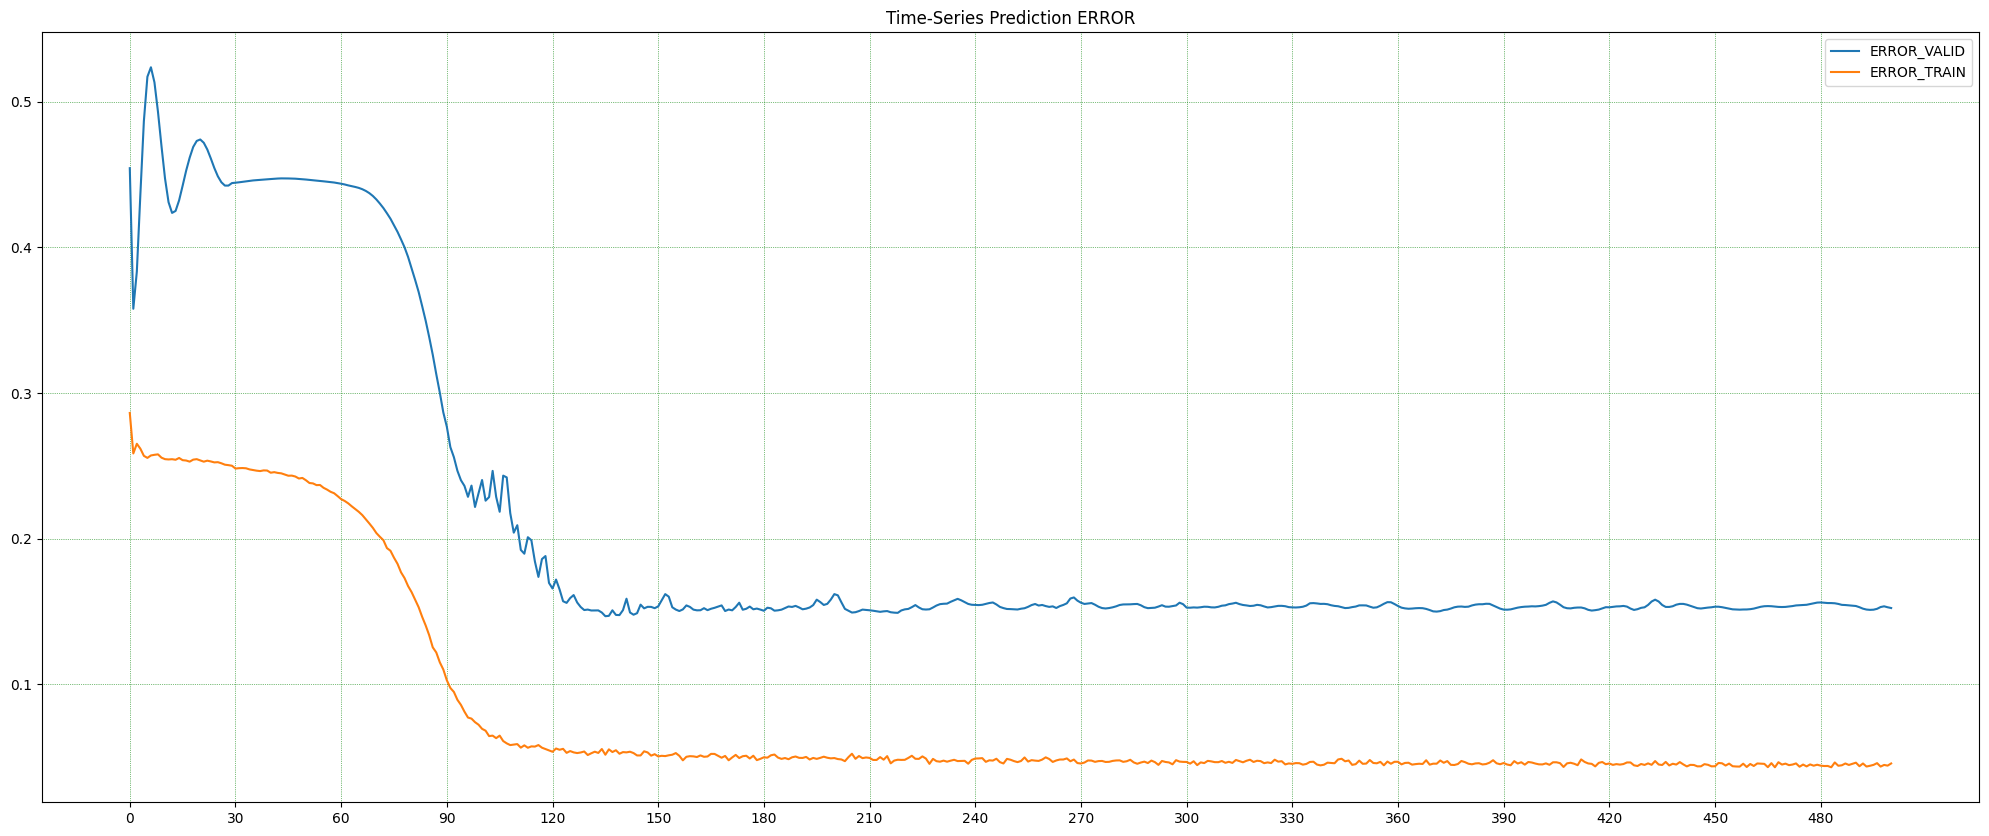

In [ ]:
plt.figure(figsize=(25,10)) #plotting
plt.plot(loss_valid_show, label='ERROR_VALID') 
plt.plot(loss_train_show, label='ERROR_TRAIN') 
plt.title('Time-Series Prediction ERROR')
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.xticks(range(0,n_epochs+1,30))
plt.legend()
plt.show()
# print(loss_show)


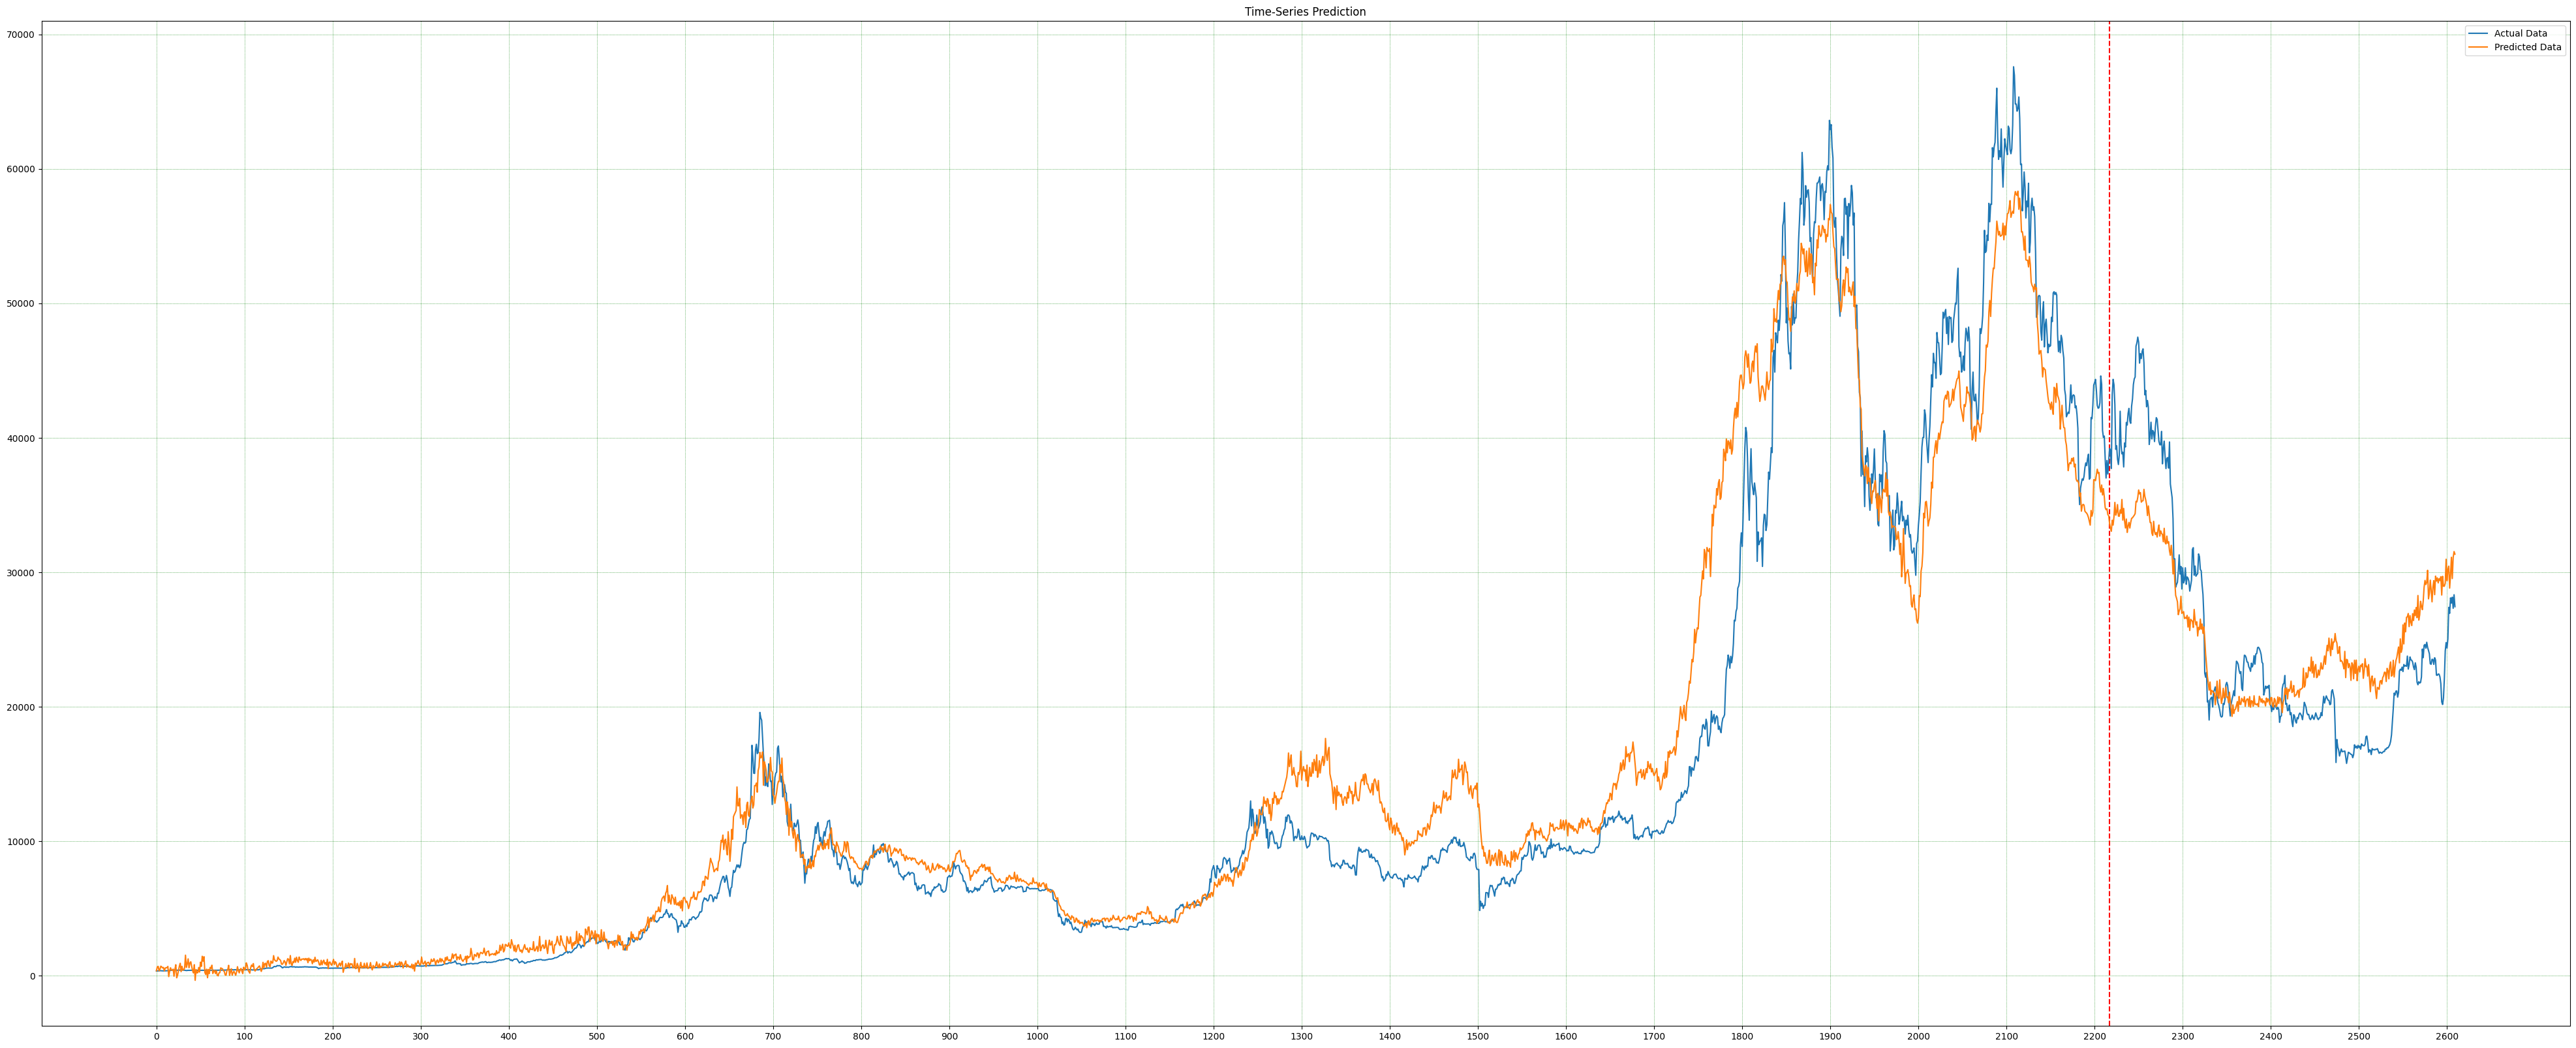

In [ ]:
df_X_ss = SScaler.transform(data[whatcol]) # old transformers
df_C_ss = condscaler.transform(Condition[ccol])

df_y_mm = MMScaler.transform(np.array(data.price_usd_close).reshape(-1, 1))
df_y_mm = df_y_mm.squeeze()
# split the sequence
df_X_ss, df_C_ss, df_y_mm = split_sequences(df_X_ss, df_C_ss, df_y_mm, x_shape, y_shape)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_C_ss = Variable(torch.Tensor(df_C_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], x_shape, df_X_ss.shape[2]))
df_C_ss = torch.reshape(df_C_ss, (df_C_ss.shape[0], x_shape, df_C_ss.shape[2]))

train_predict = myModel(df_X_ss.to(device),df_C_ss.to(device)).cpu() # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = MMScaler.inverse_transform(data_predict) # reverse transformation
dataY_plot = dataY_plot.squeeze()
dataY_plot = MMScaler.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])


plt.figure(figsize=(50,20)) #plotting
plt.axvline(x=train_test_cutoff -(x_shape), c='r', linestyle='--') # size of the training set

plt.xticks(range(0,total_samples,100))
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
# plt.savefig("whole_plot.png", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10,5)) #plotting
test_predict = myModel(X_test_tensors_final,X_test_tensors_final) # get the last sample
test_predict = test_predict.detach().cpu().numpy()
test_predict = MMScaler.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors.detach().cpu().numpy() # last sample again

test_target = MMScaler.inverse_transform(test_target[1].flatten().reshape(1, -1))
test_target = test_target[0].tolist()
# plt.xticks(range(0, 14,1))
plt.grid(color='g', linestyle='--', linewidth=0.5)
plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="Network Predictions")
plt.legend()
# plt.savefig("small_plot.png", dpi=300)
plt.show();


In [ ]:
!pip install pytorch-model-summary 
import pytorch_model_summary as pms
pms.summary(myModel, torch.zeros(X.shape[0], 28, X.shape[1]).to(device),torch.zeros(X.shape[0], 28, X.shape[1]).to(device), show_input=True, print_summary=True)